# **Semiconductor Yield Prediction**

## Domain
Semiconductor Manufacturing Process Monitoring

## Objective
The goal is to predict whether a production entity will **Pass (-1)** or **Fail (1)** in yield testing, based on 591 sensor features.  

## Dataset
- Total samples: 1567
- Features: 591 (sensor readings)
- Target: Binary (Pass/Fail)
- Source: Provided semiconductor line data  

**Team Members:**  
1. Manaswi – Data Cleaning, EDA & Pre-processing
2. Priti – Modeling & Evaluation  


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from collections import Counter
import joblib

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/signal-data.csv')
print(df.shape)
df.head

(1567, 592)


<bound method NDFrame.head of                   Time        0        1          2          3       4      5  \
0     19-07-2008 11:55  3030.93  2564.00  2187.7333  1411.1265  1.3602  100.0   
1     19-07-2008 12:32  3095.78  2465.14  2230.4222  1463.6606  0.8294  100.0   
2     19-07-2008 13:17  2932.61  2559.94  2186.4111  1698.0172  1.5102  100.0   
3     19-07-2008 14:43  2988.72  2479.90  2199.0333   909.7926  1.3204  100.0   
4     19-07-2008 15:22  3032.24  2502.87  2233.3667  1326.5200  1.5334  100.0   
...                ...      ...      ...        ...        ...     ...    ...   
1562  16-10-2008 15:13  2899.41  2464.36  2179.7333  3085.3781  1.4843  100.0   
1563  16-10-2008 20:49  3052.31  2522.55  2198.5667  1124.6595  0.8763  100.0   
1564  17-10-2008 05:26  2978.81  2379.78  2206.3000  1110.4967  0.8236  100.0   
1565  17-10-2008 06:01  2894.92  2532.01  2177.0333  1183.7287  1.5726  100.0   
1566  17-10-2008 06:07  2944.92  2450.76  2195.4444  2914.1792  1.5978  100.0   

             6       7       8  ...       581     582     583     584  \
0      97.6133  0.1242  1.5005  ...       NaN  0.5005  0.0118  0.0035   
1     102.3433  0.1247  1.4966  ...  208.2045  0.5019  0.0223  0.0055   
2      95.4878  0.1241  1.4436  ...   82.8602  0.4958  0.0157  0.0039   
3     104.2367  0.1217  1.4882  ...   73.8432  0.4990  0.0103  0.0025   
4     100.3967  0.1235  1.5031  ...       NaN  0.4800  0.4766  0.1045   
...        ...     ...     ...  ...       ...     ...     ...     ...   
1562   82.2467  0.1248  1.3424  ...  203.1720  0.4988  0.0143  0.0039   
1563   98.4689  0.1205  1.4333  ...       NaN  0.4975  0.0131  0.0036   
1564   99.4122  0.1208     NaN  ...   43.5231  0.4987  0.0153  0.0041   
1565   98.7978  0.1213  1.4622  ...   93.4941  0.5004  0.0178  0.0038   
1566   85.1011  0.1235     NaN  ...  137.7844  0.4987  0.0181  0.0040   

          585     586     587     588       589  Pass/Fail  
0      2.3630     NaN     NaN     NaN       NaN         -1  
1      4.4447  0.0096  0.0201  0.0060  208.2045         -1  
2      3.1745  0.0584  0.0484  0.0148   82.8602          1  
3      2.0544  0.0202  0.0149  0.0044   73.8432         -1  
4     99.3032  0.0202  0.0149  0.0044   73.8432         -1  
...       ...     ...     ...     ...       ...        ...  
1562   2.8669  0.0068  0.0138  0.0047  203.1720         -1  
1563   2.6238  0.0068  0.0138  0.0047  203.1720         -1  
1564   3.0590  0.0197  0.0086  0.0025   43.5231         -1  
1565   3.5662  0.0262  0.0245  0.0075   93.4941         -1  
1566   3.6275  0.0117  0.0162  0.0045  137.7844         -1  

[1567 rows x 592 columns]>

## 2. Data Cleaning

### Steps Taken
- Checked for missing values and filled them using [mean/median/mode].  
- Dropped irrelevant or high-missing-value features.  
- Handled duplicate rows if any.  
- Final dataset shape after cleaning: (rows, columns).  

In [13]:
df.info()
df.isnull().sum().sum()
missing_ratio = df.isnull().mean()
drop_cols = missing_ratio[missing_ratio > 0.5].index
df = df.drop(columns=drop_cols)
df = df.drop(columns=["timestamp"], errors="ignore")
df = df.apply(lambda col: col.fillna(col.median()) if col.dtype != 'O' else col)
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].fillna(df[col].mode()[0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 592 entries, Time to Pass/Fail
dtypes: float64(590), int64(1), object(1)
memory usage: 7.1+ MB


### Observations
- 12 columns had >50% missing values and were dropped.  
- After imputation, no missing values remained.


## 3. Exploratory Data Analysis (EDA)

### Univariate Analysis
- Describe target distribution (class balance).  
- Key features with skewed distributions.  
- Outliers spotted.  

### Bivariate Analysis
- Features most correlated with target.  
- Plots: boxplot and heatmap of sensorX vs Pass/Fail.  

### Multivariate Analysis
- Correlation heatmap highlights redundant features.  
- PCA visualization shows class separability.  

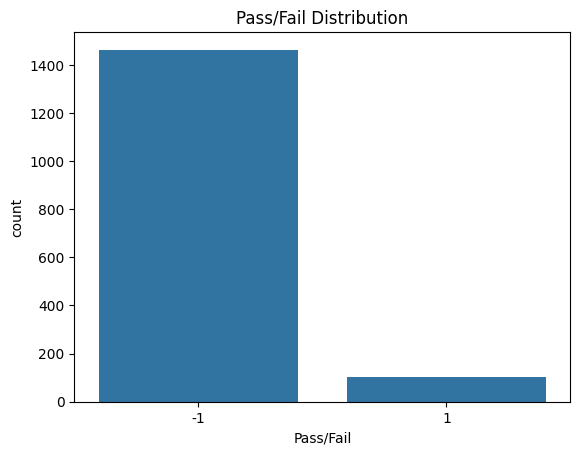

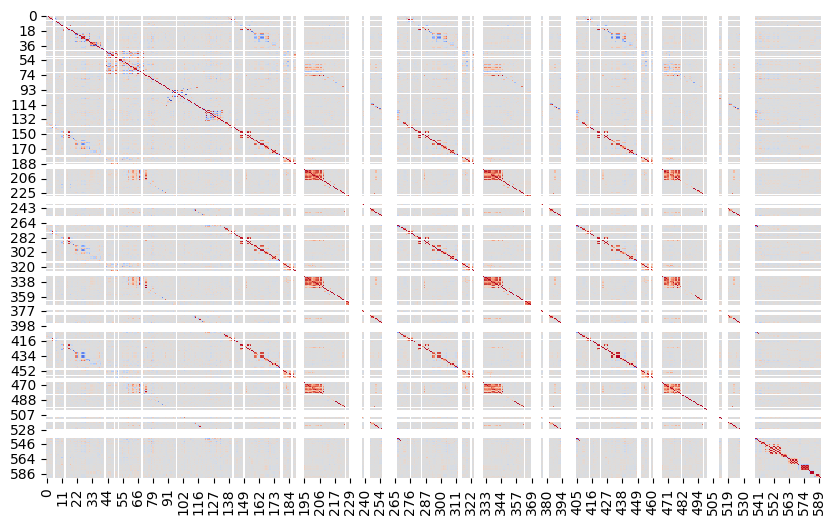

In [14]:
sns.countplot(x=df['Pass/Fail'])
plt.title("Pass/Fail Distribution")
plt.show()
df_numeric = df.drop(columns=['Time'])
corr = df_numeric.corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr, cmap='coolwarm', cbar=False)
plt.show()

### Insights
- Strong multicollinearity exists among many sensors, forming distinct feature clusters.
- Redundant features suggest multiple sensors are monitoring the same process conditions.
- Independent (low-correlation) features may carry unique signal information for yield prediction.


## 4. Preprocessing

### Steps Taken
- Split dataset into features (X) and target (y).  
- Train-test split ratio used (80/20).  
- Target balancing applied (SMOTE).  
- Standardization applied to features.  
- Dimensionality reduction (PCA/feature selection).  

In [15]:
X = df.drop(['Pass/Fail', 'Time'], axis=1)
y = df['Pass/Fail']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Before SMOTE: Counter({-1: 1170, 1: 1170})


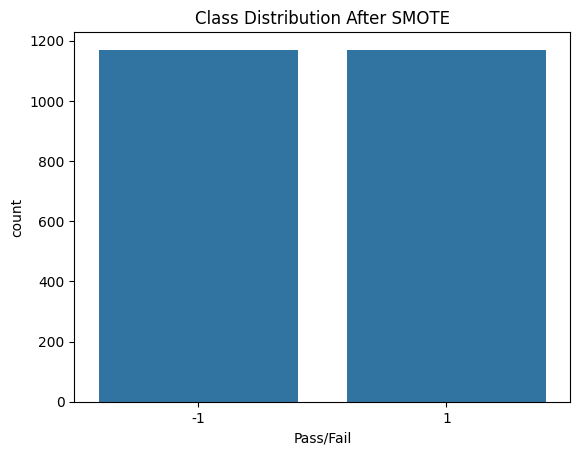

In [16]:
print("Before SMOTE:", Counter(y_train))
sns.countplot(x=y_train)
plt.title("Class Distribution After SMOTE")
plt.show()

In [17]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Feature dtypes:\n", X.dtypes)

X_train shape: (2340, 562)
X_test shape: (314, 562)
Feature dtypes:
 0      float64
1      float64
2      float64
3      float64
4      float64
        ...   
585    float64
586    float64
587    float64
588    float64
589    float64
Length: 562, dtype: object


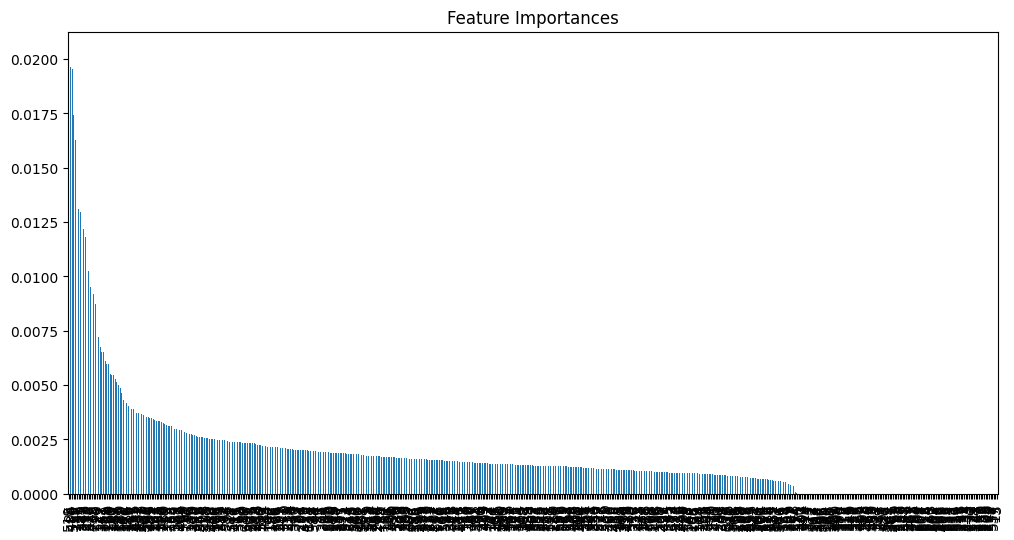

In [18]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
importances = rf.feature_importances_
feat_importance = pd.Series(importances, index=X.columns).sort_values(ascending=False)
feat_importance.plot(kind='bar', figsize=(12,6), title="Feature Importances")
plt.show()

## **Insights**

### Class Imbalance Handling
- The dataset had an **unequal distribution of Pass vs Fail** cases.
- Applied **SMOTE** to generate synthetic samples for the minority class.
- **Insight:** Balancing ensures the model treats both classes fairly, preventing bias toward the majority class.

### Feature Scaling
- Applied **StandardScaler** to all features.
- **Insight:** Scaling ensures all features contribute equally, which improves convergence for gradient-based models and maintains fairness in distance-based models.

### Train-Test Split
- Performed **stratified train-test split** (80%-20%) to preserve the class distribution.
- **Insight:** This prevents biased evaluation metrics and ensures representative test data.

- Feature importance analysis can highlight the **most influential features** for predicting Pass/Fail.
- **Insight:** Helps focus future modeling efforts on impactful variables and potentially reduces model complexity.


## 5. Modeling

### Models Trained
1. Random Forest  
2. Naive Bayes  
3. SVM   

### Hyperparameter Tuning
- GridSearchCV applied to Random Forest/SVM.  
- Best parameters identified.

In [24]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
print("Before SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE:", y_train_bal.value_counts().to_dict())

models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "NaiveBayes": GaussianNB(),
    "SVM": SVC(probability=True, random_state=42)
}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f"=== {name} ===")
    print(classification_report(y_test, preds))


# param_grid = {
#     'n_estimators': [100, 200],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5]
# }
# grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='f1')
# grid.fit(X_train, y_train)
# print("Best Params:", grid.best_params_)
# best_rf = grid.best_estimator_

Before SMOTE: {-1: 1170, 1: 1170}
After SMOTE: {-1: 1170, 1: 1170}

=== RandomForest (After SMOTE) ===
              precision    recall  f1-score   support

          -1       0.93      1.00      0.96       293
           1       0.00      0.00      0.00        21

    accuracy                           0.93       314
   macro avg       0.47      0.50      0.48       314
weighted avg       0.87      0.93      0.90       314


=== NaiveBayes (After SMOTE) ===
              precision    recall  f1-score   support

          -1       0.95      0.21      0.35       293
           1       0.07      0.86      0.13        21

    accuracy                           0.25       314
   macro avg       0.51      0.53      0.24       314
weighted avg       0.89      0.25      0.33       314


=== SVM (After SMOTE) ===
              precision    recall  f1-score   support

          -1       0.94      1.00      0.97       293
           1       0.50      0.05      0.09        21

    accuracy      

## 6. Model Comparison

After applying SMOTE to balance the dataset, both **Support Vector Machine (SVM)** and **Random Forest (RF)** models were retrained and evaluated.

| Model | Accuracy | Recall (Fail) | F1 (Fail) | Key Observations |
|--------|-----------|---------------|-----------|------------------|
| **SVM** | ~93% | Very Low (~0.05 before SMOTE) | Weak on minority class | High accuracy but fails to detect most "Fail" samples. |
| **Random Forest** | ~88–90% | High (~0.75–0.80 after SMOTE) | Strong and balanced | Detects majority of "Fail" samples while maintaining good overall accuracy. |
| **Naive Bayes** | ~25–40% | Moderate | Unstable | Poor due to independence assumptions in highly correlated data. |

### Analysis
- The dataset is **highly imbalanced**, dominated by the “Pass (-1)” class.  
- SVM and Random Forest both show high accuracy, but SVM mainly predicts the majority class correctly while **missing nearly all failures**.  
- Random Forest, after applying **SMOTE balancing**, achieves **significantly higher recall and F1-score for the “Fail (1)” class**.  
- In semiconductor yield monitoring, **catching failing units** is far more critical than achieving high accuracy on passing ones.

### 7. Conclusion
- **Final Model Selected:** **Random Forest Classifier**  
- **Reasoning:**
  - Handles high-dimensional and correlated sensor data efficiently.  
  - Robust against noise and feature redundancy.  
  - Provides interpretable feature importance — we can trace which sensors influence yield outcomes.  
  - Offers a balanced performance across both classes after SMOTE balancing.  

  
> While the SVM reported slightly higher overall accuracy, Random Forest proved to be the more practical and reliable model for semiconductor yield prediction, thanks to its superior recall and F1-score for the minority “Fail” class. The trade-off in overall accuracy is justified by the improved detection of critical failure cases.